In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = [5,3]
mpl.rcParams['text.usetex'] = True

In [3]:
def fourier_analyze(x):
    
    '''
    return the real and imaginary parts of the DFT of x
    
    A0   = DFT[0] (DC component)
    A[j] = (1/2)*(DFT[j] + DFT[-j])
    B[j] = (i/2)*(DFT[j] - DFT[-j])
    
    or , equivalently
    
    DFT[j] = A[j] - i B[j]
    
    '''
    
    N = len(x)
    
    # determine discrete frequencies
    if np.mod(N,2) == 0:
        numFreqs = int(N/2-1)
    else:
        numFreqs = int((N-1)/2)        
        
    # calculate fourier cosine and sine components for positive freqs
    A = np.zeros(numFreqs)
    B = np.zeros(numFreqs)

    for j in range(numFreqs):
        for k in range(N):
            A[j] = A[j] + x[k]*np.cos(2*np.pi*(j+1)*k/N)
            B[j] = B[j] + x[k]*np.sin(2*np.pi*(j+1)*k/N)
    
    # constant term
    A0 = np.sum(x)
    
    return A0, A, B

In [4]:
def simulate_random_fourier_sum(N, seed):
    
    '''
    simulated time series x using random DFT components
    
    
    x[k] = a0 + sum_j(positive freq) ( a[j] cos(2pi jk/N) + b[j] sin(2pi jk/N) )
    
    
    '''
    
    # set seed for random number generator
    np.random.seed(seed)
    
    # determine discrete frequencies
    if np.mod(N,2) == 0:
        numFreqs = int(N/2-1)
    else:
        numFreqs = int((N-1)/2)   
    
    # random cosine, sine coeffs 
    a0 = np.random.randn()
    a = np.random.randn(numFreqs)
    b = np.random.randn(numFreqs)
    
    # simulate time domain signal
    x = np.zeros(N)
    for k in range(N):
        for j in range(numFreqs):
            x[k] = x[k] + a[j]*np.cos(2*np.pi*(j+1)*k/N) + b[j]*np.sin(2*np.pi*(j+1)*k/N)
            
    x = x + a0
    
    return x, a0, a, b

In [5]:
def powerLaw(A, alpha, fref, N, deltaT, t0, seed):
    
    '''
    simulate evenly-sampled time series data having dimensionless characteristic strain 
    
    hc(f) = A (f/fref)^alpha
    
    and 1-sided power spectra (units time^2/Hz for timing residual measurements)
    
    P(f) =  1 /(12 pi^2 f^2) hc^2(f)/f
    
    '''
    
    # set seed for random number generator
    np.random.seed(seed)
    
    # check fref
    if fref > 1/(2*deltaT):
        print('error in powerLaw(): fref greater than fNyquist')
        return
    
    # determine discrete frequencies
    if np.mod(N,2) == 0:
        numFreqs = int(N/2 - 1)
    else:
        numFreqs = int((N-1)/2)

    T = N*deltaT   
    deltaF = 1/T
    f = deltaF*np.arange(1,numFreqs+1,1)  # arange doesn't include last value
    
    # generate ASD in frequency domain (random phases)
    # normalisation factor (discrete freqs > 0)
    Rf = 1/(12*np.pi**2 * f**2)
    hc = A * (f/fref)**alpha
    PSD = Rf * hc**2 / f
    norm = np.sqrt(N/(2*deltaT)) * np.sqrt(PSD)
    
    x = norm*np.sqrt(1./2.)*np.random.randn(numFreqs)
    y = norm*np.sqrt(1./2.)*np.random.randn(numFreqs)
    scale = norm[0]*np.sqrt(1./2.)
    r = np.sqrt(x**2 + y**2)
    z = x + 1j*y
    
    # alternative approach
    '''
    phi = np.random.uniform(0,2*np.pi,numFreqs)
    r = np.random.rayleigh(scale,numFreqs) 
    #r = scale*np.ones(numFreqs) 
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    z = x + 1j*y
    plt.plot(r)
    plt.plot(np.mean(r)*np.ones(len(r)))
    print(np.mean(r), scale*np.sqrt(np.pi/2) )
    '''
    
    if np.mod(N,2)==0:
        # note that most negative frequency is -f_Nyquist when N=even 
        temp1 = np.append(np.array([0]), z)
        temp2 = np.append(np.array([0]), np.flipud(np.conj(z)))
        dtilde = np.append(temp1, temp2)
    else:
        # no Nyquist frequency when N=odd
        temp1 = np.append(np.array([0]), z)
        dtilde = np.append(temp1, np.flipud(np.conj(z))) 
    
    # fourier transform back to time domain
    d = np.fft.ifft(dtilde)
    d = np.real(d) # imag part = 0 to round off
    
    t = t0 + deltaT*np.arange(0, N, 1)
    
    return d, t, dtilde

32 32 17 15 15
0j (-2.220446049250313e-16+0j) 8.881784197001252e-16
[-2.83915751+5.49487481j -0.06876473-0.87890729j  1.27764548+0.63897686j
 -9.06132428+3.89240955j -5.50981466-0.03399021j  7.79992293+3.96374178j
 -2.25524029-5.79555165j -3.37495035-5.80518674j  0.89815432+3.07760552j
 -1.56551086-3.85976455j  2.4220139 +1.42660611j -2.74460137+2.33186565j
  4.73344018+4.40525466j  2.1958273 -2.48345542j -1.58487626-1.7079808j ]
[-2.83915751+5.49487481j -0.06876473-0.87890729j  1.27764548+0.63897686j
 -9.06132428+3.89240955j -5.50981466-0.03399021j  7.79992293+3.96374178j
 -2.25524029-5.79555165j -3.37495035-5.80518674j  0.89815432+3.07760552j
 -1.56551086-3.85976455j  2.4220139 +1.42660611j -2.74460137+2.33186565j
  4.73344018+4.40525466j  2.1958273 -2.48345542j -1.58487626-1.7079808j ]
[-2.83915751+5.49487481j -0.06876473-0.87890729j  1.27764548+0.63897686j
 -9.06132428+3.89240955j -5.50981466-0.03399021j  7.79992293+3.96374178j
 -2.25524029-5.79555165j -3.37495035-5.80518674j  0.89

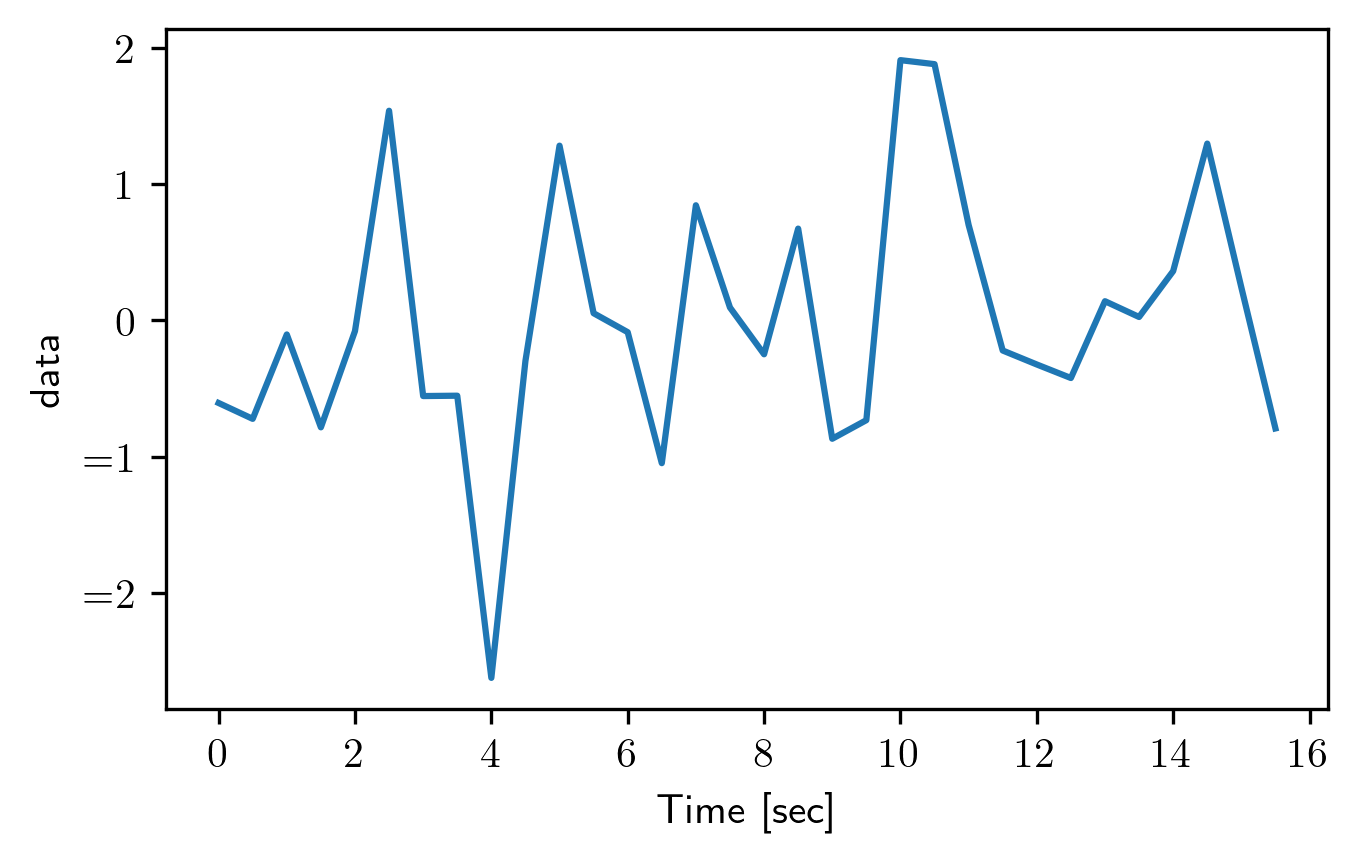

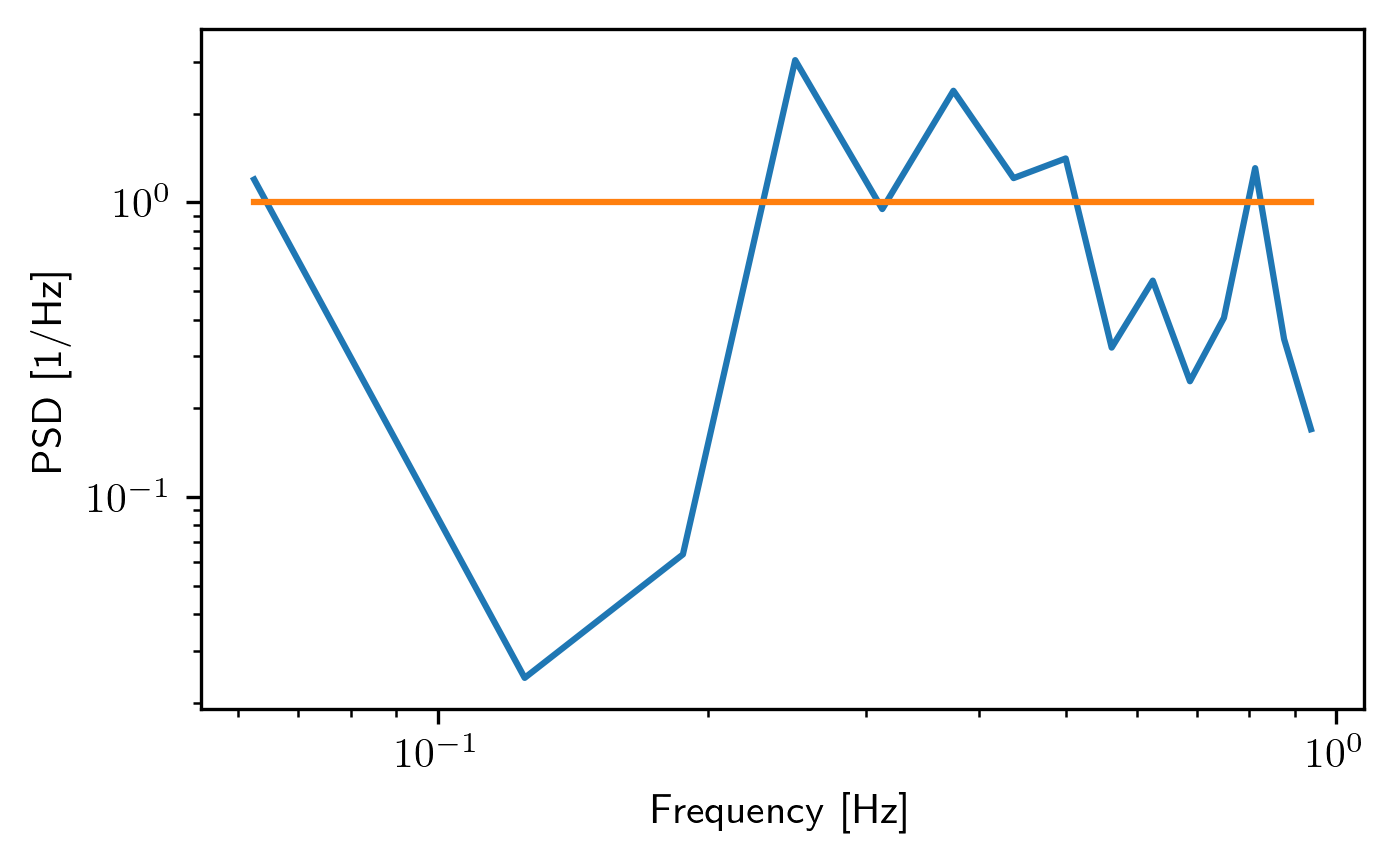

In [6]:
# simulate white noise with power spectra P = 2 sigma^2 deltaT

# parameters for white noise
sigma = 1
deltaT = 0.5
t0=0
T = 16
N = int(T/deltaT)

# convert to A, alpha
alpha = 3/2
fref = 1 # can be anything
A = np.sqrt(24*np.pi**2 * sigma**2 * deltaT * fref**3)

# simulate data
d, t, dtilde_sim = powerLaw(A, alpha, fref, N, deltaT, t0, 5678)

# time-series
plt.figure()
plt.plot(t,d)
plt.xlabel('Time [sec]')
plt.ylabel('data')
plt.savefig('simulated_data_white_time.pdf', bbox_inches='tight', dpi=400)

# power spectrum
deltaF = 1/T
numFreqs = int(N/2)
freqs = deltaF*np.arange(1,numFreqs,1)

# plot estimated PSD and reference PSD
dtilde_fft = np.fft.rfft(d) 
dtilde = dtilde_fft*deltaT
dtilde = dtilde[1:-1]
psd_est = (2/T)*np.abs(dtilde)**2
psd_ref = 2*sigma**2 * deltaT * np.ones(len(dtilde))

plt.figure()
plt.loglog(freqs, psd_est, label='simulated data')
plt.loglog(freqs, psd_ref, label='reference')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [1/Hz]')
#plt.legend()
plt.savefig('simulated_data_white_freq.pdf', bbox_inches='tight', dpi=400)

# compare fourier coefficients obtained in different ways
A0, A, B = fourier_analyze(d)

print(len(d), len(dtilde_sim), len(dtilde_fft), len(dtilde), len(A))
print(dtilde_sim[0], dtilde_fft[0], A0)
print(dtilde_sim[1:numFreqs])
print(dtilde_fft[1:-1])
print(A-1j*B)

-11.356630045833239 [ -0.13752946   2.55529096 -18.12264857 -11.01962932  15.59984586
  -4.51048059  -6.7499007 ] [ 1.79630865 -3.13102172  4.84402779 -5.48920275  9.46688037  4.39165461
 -3.16975253]
-11.356630045833237 [ -0.13752946   2.55529096 -18.12264857 -11.01962932  15.59984586
  -4.51048059  -6.7499007 ] [ 1.79630865 -3.13102172  4.84402779 -5.48920275  9.46688037  4.39165461
 -3.16975253]
[1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1.]


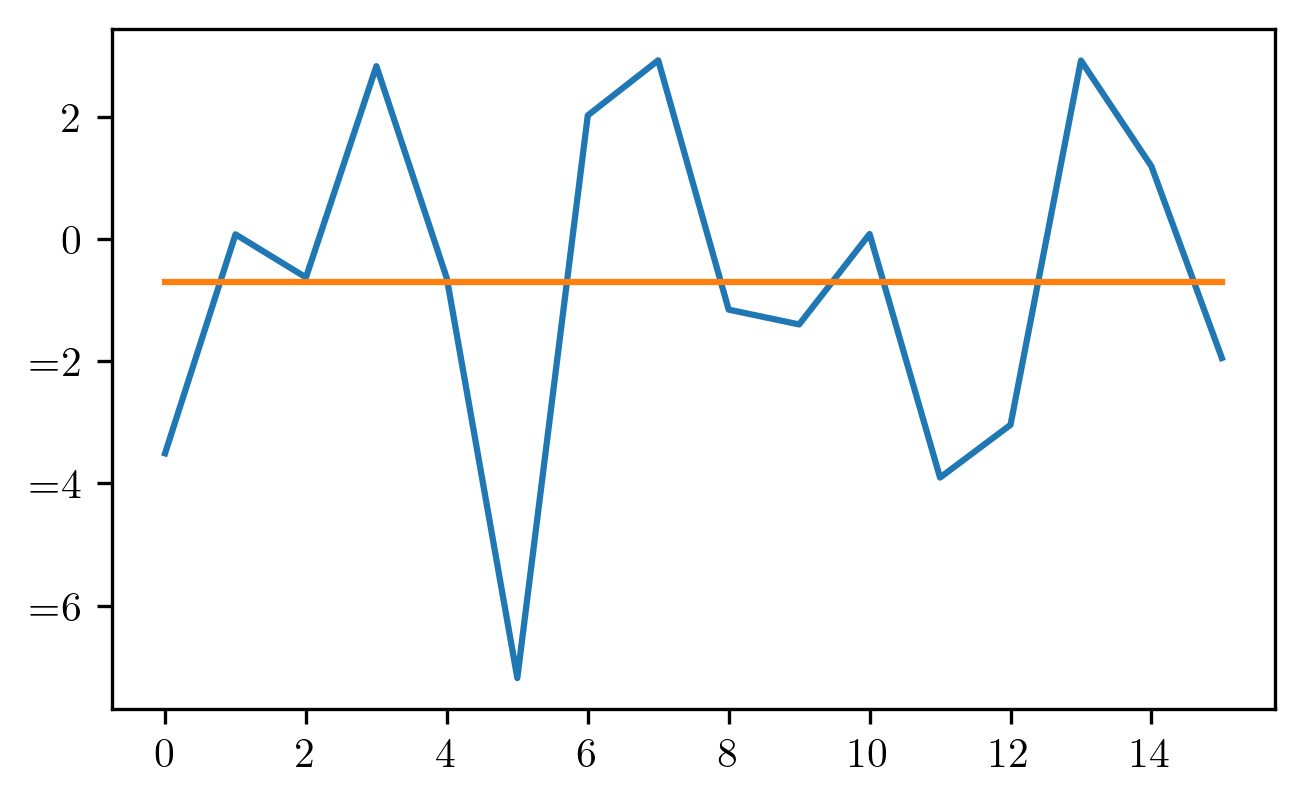

In [7]:
# test fourier_simulate / analyze routines

# simulate
N = 16
x, a0, a, b = simulate_random_fourier_sum(N, 5678)

# convert to DFT componets
A0 = N*a0
A  = N*a/2
B  = N*b/2
print(A0, A, B)

# plot signal
plt.plot(x)
plt.plot(np.mean(x)*np.ones(N))

# analyze
A0, A, B = fourier_analyze(x)
print(A0, A, B)

xdft = np.fft.rfft(x)
print(np.real(xdft[1:-1])/A)
print(-np.imag(xdft[1:-1])/B)

In [8]:
def convert_AB2ab(A0, A, B, N):
    a0 = A0/N
    a  = 2*A/N
    b  = 2*B/N
    return a0, a, b

def convert_ab2AB(a0, a, b, N):
    A0 = N*a0
    A  = N*a/2
    B  = N*b/2
    return A0, A, B

def convert_AB2H(A0, A, B, numFreqs):
    # numFreqs is number of positive freqs
    H  = np.zeros(numFreqs, dtype='complex')
    
    H0 = A0
    H  = A - 1j*B
    return H0, H

def convert_H2AB(H0, A, numFreqs):
    # numFreqs is number of positive freqs
    A = np.zeros(numFreqs)
    B = np.zeros(numFreqs)
    
    A0 = np.real(H0)
    A  = np.real(H)
    B  = -np.imag(H)
    return A0, A, B

[0.  0.5 1.  1.5 2.  2.5 3.  3.5]
1.0156779877514293
[-0.53987073 -0.22041947 -0.17342166]
[-0.31945126 -0.11588137 -0.04699781]


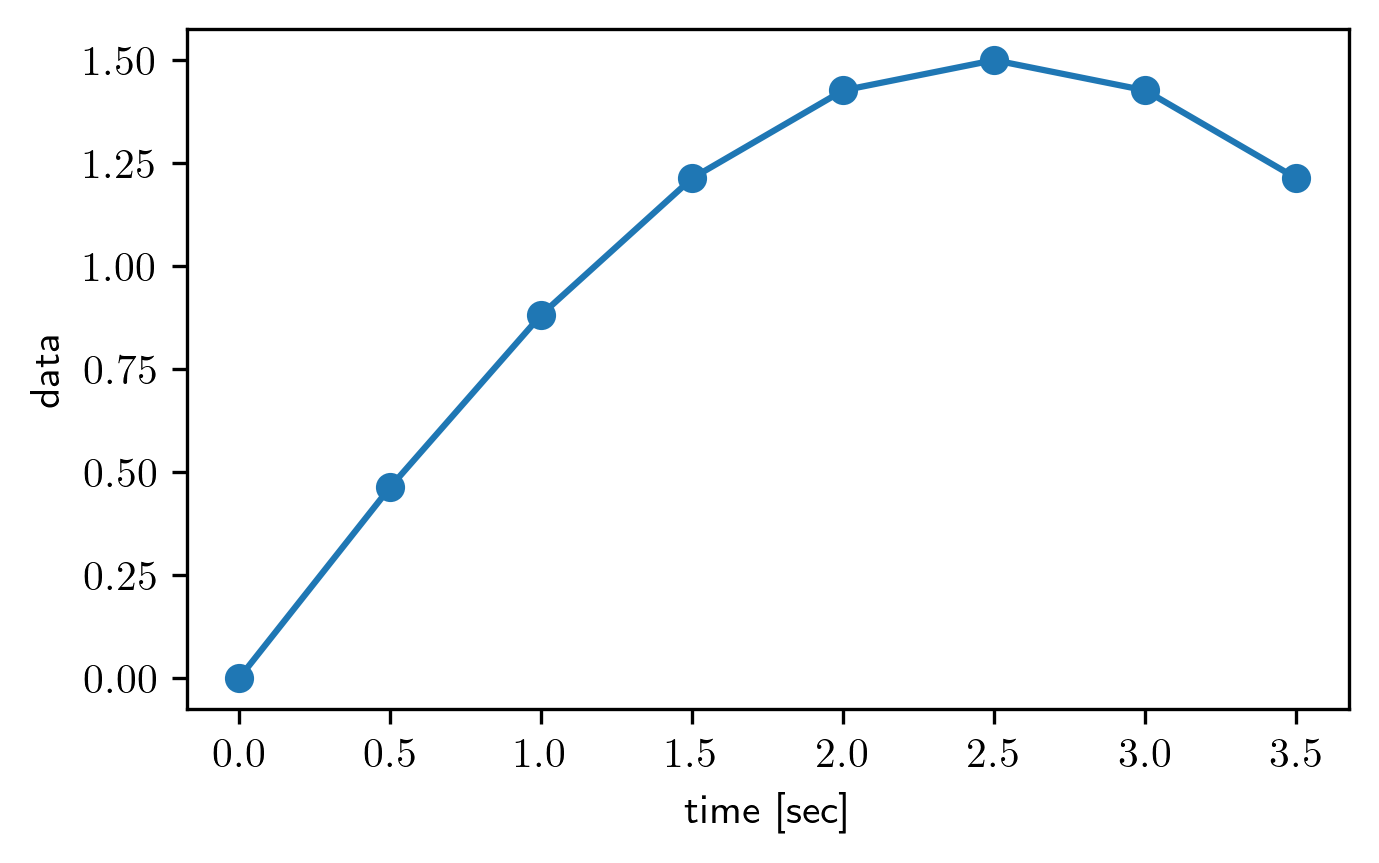

In [9]:
# simulate data

# parameters
N = 8
deltaT = 0.5
T = N*deltaT
t0 = 0
fNyq = 1/(2*deltaT)
f0 = 0.1*fNyq

# discrete times
t = np.arange(t0, T, deltaT)
print(t)

# simulate data
x = 1.5*np.sin(2*np.pi*f0*t)
plt.plot(t, x, 'o-')
plt.xlabel('time [sec]')
plt.ylabel('data')

A0, A, B = fourier_analyze(x)
a0, a, b = convert_AB2ab(A0, A, B, N)

print(a0)
print(a) 
print(b)